In [2]:
import csv
import random
import pandas as pd
from tqdm import tqdm
from itertools import islice
from vllm import LLM, SamplingParams
from transformers import AutoTokenizer

SEED = 1337
random.seed(SEED)

INFO 02-18 16:05:49 __init__.py:190] Automatically detected platform cuda.


In [3]:
df = pd.read_csv("../../data/data_raw/essays.csv")
df.head()

/tmp/ipykernel_1554/1128818070.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../../data/data_raw/essays.csv")


,essay_id,text,label,source,prompt
0,sakibsh-llm-0,"I just got back from your class, so I decided ...",0.0,sakibsh-llm-human-1,NaN
1,sakibsh-llm-1,It is 9:35 and I am beginning my stream of con...,0.0,sakibsh-llm-human-1,NaN
2,sakibsh-llm-2,Not only was the server down but it has taken ...,0.0,sakibsh-llm-human-1,NaN
3,sakibsh-llm-3,I am not exactly sure how this is supposed to ...,0.0,sakibsh-llm-human-1,NaN
4,sakibsh-llm-4,"Well, here I am on Friday, September something...",0.0,sakibsh-llm-human-1,NaN


In [4]:
df = df[df["label"] == 0]

In [5]:
df.isna().sum()

essay_id       0
text           0
label          0
source         0
prompt      2467
dtype: int64

In [6]:
df["length"] = df["text"].str.len()

In [7]:
df.sort_values("length", ascending=False).tail(10)

,essay_id,text,label,source,prompt,length
2514,sakibsh-llm-h2-47,I think obesity is bad but not that bad. If yo...,0.0,sakibsh-llm-human-2,Some states have now made it illegal to drive ...,327
2622,sakibsh-llm-h2-155,I think 1st person narrator is a nice way to t...,0.0,sakibsh-llm-human-2,Discuss a piece of literature in which the aut...,325
2499,sakibsh-llm-h2-32,"In my opinion, should we install more surveill...",0.0,sakibsh-llm-human-2,Many people feel that the use of surveillance ...,308
2532,sakibsh-llm-h2-65,My clas had to read Moby dick. I learned about...,0.0,sakibsh-llm-human-2,Discuss the events in the life of your favorit...,306
2370,sakibsh-llm-2370,I want to go to Mexico and dance I have not da...,0.0,sakibsh-llm-human-1,NaN,289
2523,sakibsh-llm-h2-56,We have to take math. I don’t like it. It is s...,0.0,sakibsh-llm-human-2,Math is a required subject. Explain why it is ...,286
2496,sakibsh-llm-h2-29,"Lot's of people are overwait and even fat, and...",0.0,sakibsh-llm-human-2,Some people think that school cafeterias shoul...,272
2541,sakibsh-llm-h2-74,Evryone shoold go to college because that educ...,0.0,sakibsh-llm-human-2,Explain how to choose the right college.,230
2257,sakibsh-llm-2257,this job is going to drain me if I don't say s...,0.0,sakibsh-llm-human-1,NaN,217
1740,sakibsh-llm-1740,alright. what can I talk about. well the only ...,0.0,sakibsh-llm-human-1,NaN,159


<Axes: >

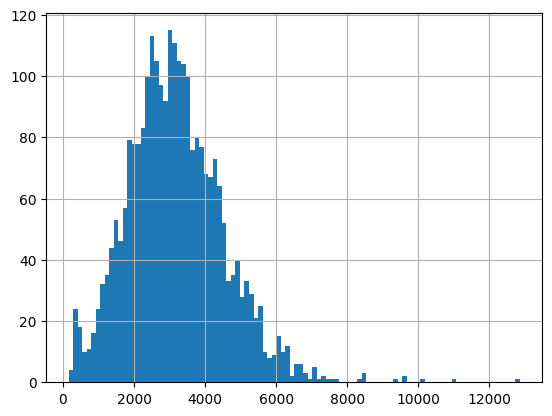

In [11]:
df["length"].hist(bins=100)

In [9]:
df.duplicated(subset="text").sum()

np.int64(0)

In [4]:
def batchify(iterable, batch_size):
    """Splits an iterable into smaller batches."""
    iterable = iter(iterable)
    while batch := list(islice(iterable, batch_size)):
        yield batch

def save_to_csv(path, prompts, responses, temperature, top_p, top_k):
    """Saves prompts, responses and sampling parameters to a CSV file."""
    with open(path, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        for prompt, response in zip(prompts, responses):
            writer.writerow([prompt, response, temperature, top_p, top_k])

def generate_responses(model, prompts, sampling_params):
    """Generate a batch of outputs using vLLM with customizable sampling parameters."""
    outputs = model.chat(prompts, sampling_params=sampling_params, use_tqdm=False)
    
    return [sample.outputs[0].text.replace('"', '') for sample in outputs]

In [5]:
BASE_PROMPT = [{"role": "system", "content": "You are a helpful asistant for rewritting students' essays. Based on provided essay generate a similar one. MAKE SURE TO REPLAY ONLY WITH THE SIMILAR ESSAY."},
                {"role": "user", "content": "Essay: \n {essay}"},
                {"role": "assistant", "content": "Similar essay: \n"}]

In [6]:
prompts = [
    [
        BASE_PROMPT[0],  # The system message
        {"role": "user", "content": BASE_PROMPT[1]["content"].format(essay=essay)},  # Formatted user message
        BASE_PROMPT[2]  # The assistant message
    ]
    for essay in df["text"].values
]

In [9]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")

In [10]:
lens = []
batch_size = 128
for prompts_batch in tqdm(batchify(prompts, batch_size), total=len(prompts) // batch_size):
    tokens = tokenizer.apply_chat_template(prompts_batch)
    lens.extend([len(token) for token in tokens])

  0%|          | 0/20 [00:00<?, ?it/s]

21it [00:04,  4.63it/s]                        


In [11]:
too_large = [i for i, l in enumerate(lens) if l > 32_768]
too_large

[]

In [7]:
df.drop(["essay_id", "label", "source", "prompt"], axis=1, inplace=True)
df.to_csv("../../data/data_human/essays.csv", index=False)

In [14]:
sampling_params = [
    SamplingParams(temperature=0.0, top_p=1.0, top_k=-1, max_tokens=30_000, seed=SEED),  # Pure Greedy (fully deterministic)
    SamplingParams(temperature=0.2, top_p=1.0, top_k=-1, max_tokens=30_000, seed=SEED),  # Highly Deterministic
    SamplingParams(temperature=0.5, top_p=0.95, top_k=100, max_tokens=30_000, seed=SEED), # Mildly Deterministic but Flexible
    SamplingParams(temperature=0.7, top_p=0.9, top_k=50, max_tokens=30_000, seed=SEED),  # Balanced and Natural
    SamplingParams(temperature=0.9, top_p=0.8, top_k=40, max_tokens=30_000, seed=SEED),  # Slightly More Diverse but Coherent
    SamplingParams(temperature=1.0, top_p=0.95, top_k=30, max_tokens=30_000, seed=SEED), # Default Creative Mode
    SamplingParams(temperature=1.2, top_p=0.7, top_k=20, max_tokens=30_000, seed=SEED),  # Highly Creative
]

In [15]:
llms = ["meta-llama/Llama-3.2-1B-Instruct"]
batch_size = 8
base_path = "../../data/data_ai/essays/essays_"

In [16]:
for llm in llms:
    model = LLM(model=llm, dtype="half", max_model_len = 10_000)
    csv_path = f"{base_path}{llm.split('/')[-1]}.csv"


    # init csv file
    with open(csv_path, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["prompt", "response", "temperature", "top_p", "top_k"])

    cnt = 0
    for prompts_batch in tqdm(batchify(prompts, batch_size), total=len(prompts) // batch_size):
        params = random.choice(sampling_params)
        responses = generate_responses(model, prompts_batch, params)
        save_to_csv(csv_path, prompts_batch, responses, params.temperature, params.top_p, params.top_k)
        cnt += 1
        if cnt > 2:
            break

WARNING 02-15 06:37:40 config.py:2386] Casting torch.bfloat16 to torch.float16.
INFO 02-15 06:37:55 config.py:542] This model supports multiple tasks: {'classify', 'embed', 'generate', 'reward', 'score'}. Defaulting to 'generate'.
INFO 02-15 06:37:55 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.2) with config: model='meta-llama/Llama-3.2-1B-Instruct', speculative_config=None, tokenizer='meta-llama/Llama-3.2-1B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=10000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, c

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 02-15 06:38:09 model_runner.py:1115] Loading model weights took 2.3185 GB
INFO 02-15 06:38:12 worker.py:267] Memory profiling takes 2.84 seconds
INFO 02-15 06:38:12 worker.py:267] the current vLLM instance can use total_gpu_memory (6.00GiB) x gpu_memory_utilization (0.90) = 5.40GiB
INFO 02-15 06:38:12 worker.py:267] model weights take 2.32GiB; non_torch_memory takes 0.04GiB; PyTorch activation peak memory takes 1.21GiB; the rest of the memory reserved for KV Cache is 1.84GiB.
INFO 02-15 06:38:13 executor_base.py:110] # CUDA blocks: 3761, # CPU blocks: 8192
INFO 02-15 06:38:13 executor_base.py:115] Maximum concurrency for 10000 tokens per request: 6.02x
INFO 02-15 06:38:23 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utiliz

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:31<00:00,  1.12it/s]

INFO 02-15 06:38:55 model_runner.py:1562] Graph capturing finished in 32 secs, took 0.12 GiB
INFO 02-15 06:38:55 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 45.39 seconds



  0%|          | 0/329 [00:00<?, ?it/s]

INFO 02-15 06:38:55 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.


  1%|          | 2/329 [02:48<7:38:34, 84.14s/it]


In [17]:
df = pd.read_csv("../../data/data_ai/essays/essays_Llama-3.2-1B-Instruct.csv")
df.head()

,prompt,response,temperature,top_p,top_k
0,"[{'role': 'system', 'content': ""You are a help...","I recently attended my first class, and I'm ex...",1.2,0.7,20
1,"[{'role': 'system', 'content': ""You are a help...",It's 9:35 and I'm starting my stream of consci...,1.2,0.7,20
2,"[{'role': 'system', 'content': ""You are a help...","As I sat in front of my computer, the server s...",1.2,0.7,20
3,"[{'role': 'system', 'content': ""You are a help...",I'm happy to help you with rewriting your essa...,1.2,0.7,20
4,"[{'role': 'system', 'content': ""You are a help...","I'm writing this essay on Friday, September 15...",1.2,0.7,20
